# Import and Define

In [1]:
from plot import *
import numpy as np
import pandas as pd
import polars as pl
from huggingface_hub import hf_hub_download, snapshot_download

from scipy.stats import spearmanr
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    auc,
    RocCurveDisplay,
    average_precision_score,
    PrecisionRecallDisplay,
)
from tqdm import tqdm

tqdm.pandas()

/accounts/grad/czye/conda/envs/gpn_env/envs/gpn_star/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
palette = {
    "GPN-Star": "#2773BA",
    "PhyloP": "#9E66BA",
    "PhastCons": "#C4494B",
}

In [3]:
# model groups

gpn_star_models = ["GPN-Star"]

genome_wide_veps = [
    "PhyloP",
    "PhastCons",
]

In [4]:
WORK_DIR = "tmp/"

# 1001GP rare vs. common enrichment

In [5]:
snapshot_download(
    repo_id="songlab/1001gp", local_dir=f"{WORK_DIR}/1001gp", repo_type="dataset"
)

Fetching 6 files: 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]


'/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/tmp/1001gp'

In [6]:
V_1001gp = pd.read_parquet(f"{WORK_DIR}/1001gp/test.parquet")

all_models = genome_wide_veps + gpn_star_models
for m in all_models:
    V_1001gp[m] = pd.read_parquet(f"{WORK_DIR}/1001gp/predictions/{m}.parquet")

In [7]:
V_1001gp = pl.from_pandas(V_1001gp)  # compute in polars for efficiency
V_1001gp

chrom,pos,ref,alt,AC,AF,consequence,label,PhyloP,PhastCons,GPN-Star
str,i32,str,str,i64,f64,str,bool,f64,f64,f64
"""1""",284,"""T""","""A""",1,0.000493,"""intergenic""",true,-0.7031,0.000292,0.285688
"""1""",286,"""T""","""A""",1,0.000493,"""intergenic""",true,-1.644564,0.00007,0.747328
"""1""",288,"""A""","""G""",1,0.000493,"""intergenic""",true,0.214873,0.002629,0.812442
"""1""",298,"""C""","""T""",1,0.000493,"""intergenic""",true,0.090109,0.029638,0.479579
"""1""",301,"""G""","""A""",1,0.000493,"""intergenic""",true,0.189161,0.005228,0.42391
…,…,…,…,…,…,…,…,…,…,…
"""5""",26975204,"""G""","""A""",1,0.000493,"""intergenic""",true,0.743548,0.010251,-0.002846
"""5""",26975213,"""C""","""T""",1,0.000493,"""intergenic""",true,-0.540382,0.000073,2.789362
"""5""",26975221,"""T""","""G""",1,0.000493,"""intergenic""",true,-0.789413,0.000323,-0.13971


In [8]:
results_1001gp = []
for c in tqdm(V_1001gp["consequence"].unique().to_list() + ["all"]):
    if c != "all" and (V_1001gp["consequence"] == c).sum() < 500:
        continue
    df_c = (
        V_1001gp.clone() if c == "all" else V_1001gp.filter(pl.col("consequence") == c)
    )
    df_c = df_c.drop_nulls(subset=all_models)
    n_pos, n_neg = df_c["label"].sum(), (~df_c["label"]).sum()
    for m in all_models:
        try:
            if m not in gpn_star_models:
                # Fix: Apply negation to the score column instead of the DataFrame
                selected_df = df_c.select(["label", pl.col(m).alias("score")])
                selected_df = selected_df.with_columns(pl.col("score") * -1)
                odds_ratio = get_odds_ratio(selected_df, [30]).with_columns(
                    Consequence=pl.lit(c),
                    Model=pl.lit(m),
                    n_pos=pl.lit(n_pos),
                    n_neg=pl.lit(n_neg),
                )
                results_1001gp.append(odds_ratio)
            else:
                odds_ratio = get_odds_ratio(
                    df_c.select(["label", pl.col(m).alias("score")]), [30]
                ).with_columns(
                    Consequence=pl.lit(c),
                    Model=pl.lit(m),
                    n_pos=pl.lit(n_pos),
                    n_neg=pl.lit(n_neg),
                )
                results_1001gp.append(odds_ratio)
        except:
            pass

results_1001gp = pl.concat(results_1001gp).to_pandas()
results_1001gp.head()

100%|██████████| 16/16 [00:01<00:00, 14.89it/s]


,n,Odds ratio,p_value,Consequence,Model,n_pos,n_neg
0,30,5.405237,6.842600e-32,splice_region,PhyloP,69240,22218
1,30,4.169142,6.860161e-21,splice_region,PhastCons,69240,22218
2,30,14.436306,5.490826e-123,splice_region,GPN-Star,69240,22218
3,30,11.219807,2.493579e-92,non_coding_transcript_exon,PhyloP,39639,8930
4,30,13.393615,2.751683e-115,non_coding_transcript_exon,PhastCons,39639,8930


In [9]:
replacements = {
    "5_prime_UTR": "5' UTR",
    "3_prime_UTR": "3' UTR",
    "upstream_gene": "upstream-of-gene",
    "downstream_gene": "downstream-of-gene",
    "splice_region": "splice-region",
    "start_or_stop": "start-or-stop",
}
results_1001gp["Consequence"] = results_1001gp["Consequence"].replace(replacements)

In [10]:
results_1001gp = results_1001gp.sort_values("Odds ratio", ascending=False)

/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:414: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(


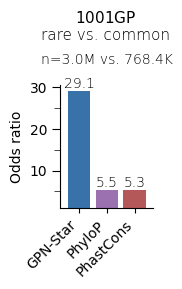

In [11]:
barplot_vertical(
    results_1001gp[
        (results_1001gp.p_value < 0.05) & (results_1001gp.Consequence == "all")
    ],
    "Odds ratio",
    r"$\bf{\sf{1001GP}}$" + "\nrare vs. common",
    y=1.35,
    width=1.2,
    height=1.6,
    palette=palette,
)

/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:293: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:293: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:293: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/workflow/notebooks/plot.py:293: FutureWarning: 

Passing `palette`

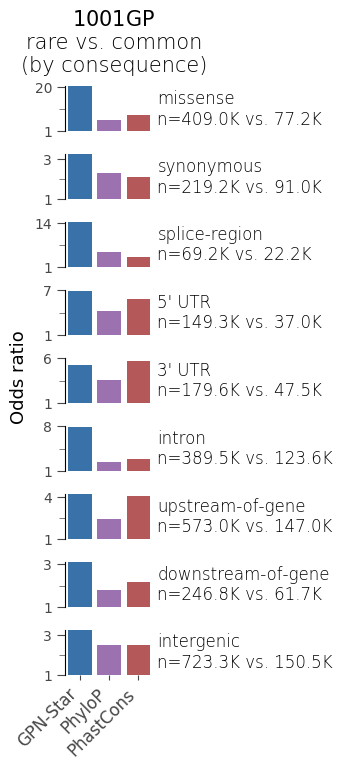

In [12]:
barplot_vertical_aligned(
    results_1001gp[(results_1001gp.n == 30) & (results_1001gp.p_value < 0.05)],
    metric="Odds ratio",
    title=r"$\bf{\sf{1001GP}}$" + "\nrare vs. common\n(by consequence)",
    palette=palette,
    width=1.3,
    height=0.85,
    hspace=0.5,
    suptitle_y=0.98,
    model_order=[
        "GPN-Star",
        "PhyloP",
        "PhastCons",
    ],
    group_order=[
        "missense",
        "synonymous",
        "splice-region",
        "5' UTR",
        "3' UTR",
        "intron",
        "upstream-of-gene",
        "downstream-of-gene",
        "intergenic",
    ],
)